### Parsing IPFIX Data
The `netflow.csv` file contains pre-processed netflow data from a Princeton campus network border router. The data is "unsampled," i.e. it compiles flow statistics for every packet that traverses any interface on the border router. 

```
Date first seen, Time first seen (m:s), Date last seen, Time last seen (m:s), Duration (s), Protocol, 
Src IP addr, Src port, Dst IP addr, Dst port, Packets, Bytes, Flags, Input interface, Output interface		

```


In [1]:
import csv

with open('netflow.csv', 'r') as netflow_file:
    netflow_reader = csv.DictReader(netflow_file)
    netflow_data = list(netflow_reader)
    
print (f"number of netflow records {len(netflow_data)}")
print (f"sample netflow record \n{netflow_data[0]}")

number of netflow records 105360
sample netflow record 
{'Date first seen': '10/29/15', 'Time first seen (m:s)': '04:48.9', 'Date last seen': '10/29/15', 'Time last seen (m:s)': '04:48.9', 'Duration (s)': '0', 'Protocol': 'ICMP', 'Src IP addr': '172.16.241.1', 'Src port': '0', 'Dst IP addr': '128.112.213.189', 'Dst port': '11', 'Packets': '1', 'Bytes': '94', 'Flags': '.A....', 'Input interface': '120', 'Output interface': '0'}


 many attackers attempt to detect hosts running vulnerable services by scanning the address space using TCP SYN packets.  If a NetFlow record indicates that a flow contained a TCP SYN packet _but no packets with the ACK flag set_, we can conclude that this flow never completed and thus may be part of a TCP SYN scan---particularly if there are a lot of these flows.
 When an attacker sends a TCP SYN packet as part of a TCP SYN scan, there are three possible outcomes:
- There is an active host at the destination IP address that is listening on the destination port of the SYN packet. In this case, the NetFlow record will contain both the TCP SYN and ACK flags in the flow record. These flows are difficult to distinguish from legitimate flows, because in this case a host actually answered the initial SYN. 
- There is no active host on the network at the destination IP address. In this case, we will only see TCP SYN flag. This is very different from the legitimate traffic behavior. It should be possible to identify malicious scanners by identifying these flows.
- The destination is alive, but the port to which the SYN is sent is closed. If a client connects to a server's non-listening port, the server will send back a RST/ACK packet. According to normal TCP implementation guidelines, the scanner will immediately stop any TCP connection attempts once it receives a RST. Like in the previous case, the NetFlow record will show SYN requests from the scanner host to the destination host but no SYN/ACK packets in response.

### PART A: TCP SYN Scan Detection
In this part we calculate the percentage SYN only flow in the network which is used to inspect if the network has some kind of malicious flow.

In [2]:
tcp_only_count = 0
tcp_syn_only_count = 0
for i in netflow_data:
    if i['Protocol'] == 'TCP':
        tcp_only_count += 1
        if 'S' in i['Flags'] and 'A' not in i['Flags'] and 'F' not in i['Flags']:
            tcp_syn_only_count += 1

print (f"TCP only: {tcp_only_count}")
print (f"TCP SYN only: {tcp_syn_only_count}")

tcp_syn_only_ratio = tcp_syn_only_count / tcp_only_count
print (f"TCP SYN only ratio: {tcp_syn_only_ratio}")

TCP only: 73494
TCP SYN only: 64993
TCP SYN only ratio: 0.8843306936620676


We set a threshold to decide whether to consider some percentage indicative of malicious activity

### PART B: Port Scan Detection Using Known Bad Ports
Another method of identifying attacks involves using TCP ports that are known to correspond to particularly vulnerable services. we will consider ports 135, 139, 445, and 1433 as known bad ports. These correspond to Windows RPC, NetBIOS, SMB, and SQL-Snake attacks. We expect that most of the traffic to "known bad" ports are scanners, but that is not necessarily true for all traffic to these ports.

we calculate the following three percentages, store them in variables, and print them with informative labels:
   1. Precent of flows to known bad ports out of all TCP flows
   2. Percent of SYN-only flows out of all TCP flows to known bad ports
   3. Percent of SYN-only flows out of all TCP flows to other ports

In [3]:
bad_ports = ["135", "139", "445", "1433"]

tcp_flow_count = 0
syn_only_bad_ports_count = 0
other_bad_ports_count = 0
syn_only_other_ports_count = 0
other_other_ports_count = 0

for i in netflow_data:
    if i['Protocol'] == 'TCP':
        tcp_flow_count += 1
        if 'S' in i['Flags'] and 'A' not in i['Flags']:
            if i['Dst port'] in bad_ports:
                syn_only_bad_ports_count += 1
            else:
                syn_only_other_ports_count += 1
        else:
            if i['Dst port'] in bad_ports:
                other_bad_ports_count += 1
            else:
                other_other_ports_count += 1

print(f"Precent of flows to known bad ports out of all TCP flows {(syn_only_bad_ports_count+other_bad_ports_count)/tcp_flow_count} ")
print(f"Percent of SYN-only flows out of all TCP flows to known bad ports {syn_only_bad_ports_count/(syn_only_bad_ports_count+other_bad_ports_count)} ")
print(f"Percent of SYN-only flows out of all TCP flows to other ports {syn_only_other_ports_count/(syn_only_other_ports_count+other_other_ports_count)} ")

Precent of flows to known bad ports out of all TCP flows 0.05895719378452663 
Percent of SYN-only flows out of all TCP flows to known bad ports 0.9979229171474728 
Percent of SYN-only flows out of all TCP flows to other ports 0.8772140368126545 


Here we can see that the syn only flow to known bad ports is in higher proportion as compared to other ports indicative of syn scan targeted on them

But we would also like to identify the potentially malicious hosts. We identify the malicious, benign and questionable hosts here like this-
1. Find the set of all hosts (IP addresses) that sent SYN-only or known bad port flows to Princeton during the recorded netflow data. We will call these the "malicious hosts"
2. Find the set of all hosts that sent non-SYN-only flows to other (not known bad) ports. We will call these the "benign hosts"
2. Find the intersection of the malicious hosts with the benign hosts. We will call this intersection the "questionable" hosts.
3. Remove these "questionable" hosts from the "malicious hosts" and "benign hosts" sets.

We then print a few informative statistics over them

In [4]:
def internalIP(ip):
    s = ip.split('.')
    if s[0] == "128" and s[1] == "112":
        return True
    return False

malicious_host = set()
benign_host = set()
questionable_host = set()

for i in netflow_data:
    if i['Protocol'] == 'TCP' and not internalIP(i['Src IP addr']) and (('S' in i['Flags'] and 'A' not in i['Flags']) or (i['Dst port'] in bad_ports)):
        malicious_host.add(i['Src IP addr'])
    if i['Protocol'] == 'TCP' and not internalIP(i['Src IP addr']) and i['Dst port'] not in bad_ports and not ('S' in i['Flags'] and 'A' not in i['Flags']):
        benign_host.add(i['Src IP addr'])

questionable_host = malicious_host & benign_host
malicious_filtered = malicious_host - questionable_host
benign_filtered = benign_host - questionable_host

print(f"Number of malicious hosts: {len(malicious_filtered)}")
print(f"Number of benign hosts: {len(benign_filtered)}")
print(f"Number of questionable hosts: {len(questionable_host)}")

Number of malicious hosts: 4479
Number of benign hosts: 66
Number of questionable hosts: 12


### PART C: Bro's Port Scan Detection Algorithm
This method is used for detecting malicious host in realtime. 
The port scan detection algorithm used in the [Bro system](https://pdfs.semanticscholar.org/f121/cde8d3d5364717caf2b91d27a270ec004cac.pdf) was published in 1999 by Vern Paxson, et al.

Bro's detection algorithm builds on the same intution that failed connection attempts (SYN-only or SYN/RST flows) are good indicators for identifying scans.

The algorithm treats connection attempts differently depending on the service (determined by port) to which the connection is intended.  Bro only tracks failed connection attempts (SYN-only or SYN/RST) to a specific set of "known good" services.

For all other services, Bro tracks all connection attempts, whether or not the attempts fail or succeed. 

For each sending host, Bro counts the number of distinct destination addresses corresponding to tracked connection attempts. If the number exceeds some threshold, `T`, Bro flags the host as a scanner.

By default, the set of services for which only failures are considered includes HTTP (80), SSH (22), Telnet (23), SMTP (25), IDENT (113), FTP (20), and Gopher (70). These services are "known good," i.e. we expect many connections to be initiated to these services, so we should not count successful connection attempts against a sending host. 

In [5]:
from collections import defaultdict

class Bro:
    
    # class constructor saves the parameter threshold value and sets instance variables
    def __init__(self, threshold):
        self.T = threshold
        
        # self.good_services is the list of port numbers to which successful connections 
        #     (SYN and ACK) should not be tracked
        self.good_services = [80, 22, 23, 25, 113, 20, 70]
        
        # self.tracked maps sending hosts to a set of destination addresses
        #     from tracked connection attempts 
        self.tracked = defaultdict(set)

    def block_connection(self, host_ip):
        if host_ip in self.tracked:
            if len(self.tracked[host_ip]) >= self.T:
                return True
        return False
    
    def process_flow(self, netflow_record):
        i = netflow_record
        if i['Protocol'] == 'TCP' and not internalIP(i['Src IP addr']) and i['Dst port'] not in self.good_services:
            self.tracked[i['Src IP addr']].add(i['Dst IP addr'])
            
        if i['Protocol'] == 'TCP' and not internalIP(i['Src IP addr']) and i['Dst port'] in self.good_services and 'S' in i['Flags'] and 'A' not in i['Flags']:
            self.tracked[i['Src IP addr']].add(i['Dst Ip addr'])


`run_bro()` function takes a threshold value and runs your Bro algorithm on the NetFlow data, returning a set of all addresses blocked during the course of the algorithm. This function is already complete.

In [6]:
from tqdm import tqdm
def run_bro(threshold):
    blocked_hosts = set()
    bro = Bro(threshold)
    for flow in tqdm(netflow_data):
        src_ip = flow["Src IP addr"]
        if flow["Protocol"] != "TCP":
            continue
        if internalIP(src_ip):
            continue
        block = bro.block_connection(src_ip)
        if block:
            blocked_hosts.add(src_ip)
            continue
        bro.process_flow(flow)
    return blocked_hosts      

```plot_bro()``` is a utility for plortting the distribution of blocked hosts

100%|██████████| 105360/105360 [00:00<00:00, 1902430.90it/s]


[1746, 255, 213, 166, 137, 136, 132, 126, 125, 116, 113, 111]


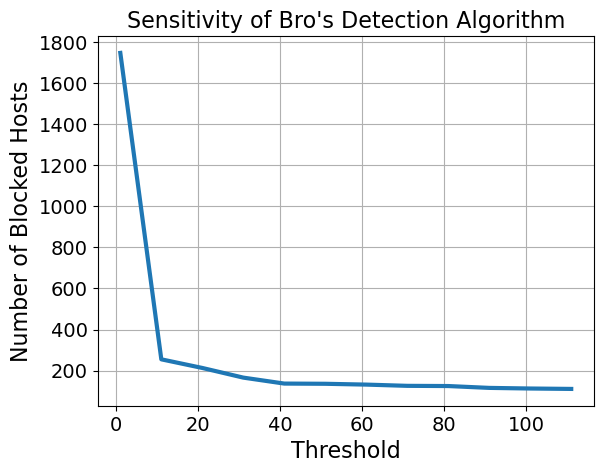

In [9]:
import matplotlib.pyplot as plt

num_blocked_hosts = []
for i in range(1,120,10):
    blocked_hosts = run_bro(i)
    num_blocked_hosts.append(len(blocked_hosts))
# plt.plot(range(1,120,10), num_blocked_hosts, linewidth=3)
# plt.show()
print(num_blocked_hosts)
plt.plot(range(1,120,10), num_blocked_hosts, linewidth=3)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Number of Blocked Hosts", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Sensitivity of Bro's Detection Algorithm", fontsize=16)
plt.grid()
# plot_bro(num_blocked_hosts)